$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$



# Autoencoders

### ITCS4156

### Minwoo "Jake" Lee

# Goal

The goal of this activity is to implement undercomplete autoencoder to learn latent representation of our previously used [Abalone data](https://archive.ics.uci.edu/ml/datasets/Abalone). These learned representations will be of a lower dimensionality compared to the inputs, hence undercomplete. Thus, we are trying to compress our representations into a form that contains only the most salient aspects of the input. We will use the encoded  representation to classify the gender as we did before. Let's see if we can get any improvement in our accuracy performance with autoencoders. Follow the TODO titles and comments to finish the activity!

# Agenda

1. Data Loading, Preprocessing, and Visualization
    * Load
    * Visualization
    * Data Preprocessing
2. Autoencoders
3. Classification

In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import pandas as pd
from copy import deepcopy as copy

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'   #TF2: to fix Jupyter down

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import IPython.display as ipd  # for display and clear_output

# Loading, Preprocessing, and Visualization

The dataset we'll be using this week is the Abalone Dataset (pronounced ab·​a·​lo·​ne). For those that don't know, abalone are marine snails. The original goal of this data is to predict the age of a given abalone. Typically, this is done by counting the number of rings the shell contains (much like tree ring counting). However, counting the rings of an abalone shell is expensive (see description below). Thus, the authors of the data wish to use other features to predict age. **It turns out that predicting age is actually quite hard, so we'll focus on predicting other features such as sex. More on this later...**

> Predicting the age of abalone from physical measurements. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict the age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.



## Loading

In [2]:
names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

abalone_df = pd.read_csv("abalone.data", names=names)
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Below is the descriptions of our features found in the 'abalone.names' files.

    Sex		    nominal			M, F, and I (infant)
    Length		continuous	mm	Longest shell measurement
    Diameter	continuous	mm	perpendicular to length
    Height		continuous	mm	with meat in shell
    Whole weight	continuous	grams	whole abalone
    Shucked weight	continuous	grams	weight of meat
    Viscera weight	continuous	grams	gut weight (after bleeding)
    Shell weight	continuous	grams	after being dried
    Rings		integer			+1.5 gives the age in years

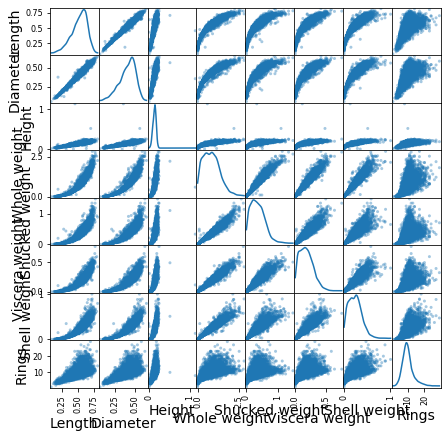

In [3]:
from pandas.plotting import scatter_matrix
scatter_matrix(abalone_df, alpha=0.4, figsize=(7,7), diagonal='kde');

## Data Visualization

### Scatter matrix

Let's do a quick Pandas `scatter_matrix()` plot to see how our features correlate with one another and observer each features data distribution.

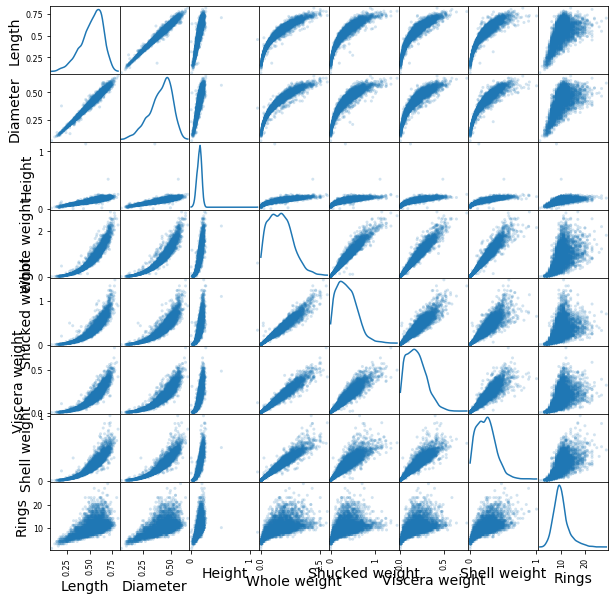

In [3]:
from pandas.plotting import scatter_matrix

scatter_matrix(abalone_df, alpha=0.2, figsize=(10,10), diagonal='kde');

## Data Preprocessing

Let's go ahead an do our typical data processing of splitting the data into training features `X` and target feature `T`.

In [4]:
X = abalone_df.iloc[:, 1:].copy()
T = abalone_df[['Sex']].copy()

In [5]:
X

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [6]:
T

,Sex
0,M
1,M
2,F
3,M
4,I
...,...
4172,F
4173,M
4174,M
4175,F


Here we convert our string labels into numerical values. We don't necessarily have to use indicators variables when our target is made up of categorical variables. We always have to use indicator variables when we have categorical variables within our training/testing data though!

In [7]:
Tdic = {'M': 0, 'F':1, 'I':2 }

Tl = T['Sex'].apply(lambda x: Tdic[x]) 
Tl

0       0
1       0
2       1
3       0
4       2
       ..
4172    1
4173    0
4174    0
4175    1
4176    0
Name: Sex, Length: 4177, dtype: int64

### Data Partitioning

It's that time again, time to use our `partitionlib.py` Python file for data partitioning. Let's copy the `partitionlib.py` Python file into the directory where this notebook is running! If you don't have this file go to the Files tab in Canvas to download the `partitionlib.py` Python file. 

In [8]:
import partitionlib as ptl
# just in case, you made change in the file, you may need to reload as below
import importlib
import partitionlib
importlib.reload(partitionlib);

In [9]:
def partition_data(X, T):
    """Partition data into train and test splits."""
    data, targets = ptl.partition(copy(X.values), copy(T.values))
    Xtrain, Xtest = data
    Ttrain, Ttest = targets
    
    return Xtrain, Xtest, Ttrain, Ttest

In [10]:
Xtrain, Xtest, Ttrain, Ttest = partition_data(X, Tl)
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (3342, 8)
Train target shape: (3342, 1)
Test data shape: (835, 8)
Test target shape: (835, 1)


In [11]:
N, D = X.shape
Ntrain, Ntest = Xtrain.shape[0], Xtest.shape[0]
print("Number of total samples: {}".format(N))
print("Number of total features: {}".format(D))
print("Number of training samples: {}".format(Ntrain))
print("Number of testing samples: {}".format(Ntest))

Number of total samples: 4177
Number of total features: 8
Number of training samples: 3342
Number of testing samples: 835


### Standardize

In [12]:
def standardize(X, mean, std):
    return (X-mean) / std

In [13]:
mean = np.mean(Xtrain, axis=0)
std = np.std(Xtrain, axis=0)

XtrainS = standardize(Xtrain, mean, std)
XtestS = standardize(Xtest, mean, std)

In [14]:
pd.DataFrame(XtrainS).describe()

,0,1,2,3,4,5,6,7
count,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03,3.342000e+03
mean,2.308413e-15,-2.041887e-14,1.218428e-14,-8.989418e-16,2.197325e-15,-5.541149e-16,2.018068e-15,-6.982911e-17
std,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00
min,-3.298514e+00,-3.115013e+00,-3.570862e+00,-1.661568e+00,-1.601386e+00,-1.625908e+00,-1.680331e+00,-2.472902e+00
25%,-6.225500e-01,-5.889836e-01,-6.239864e-01,-7.914965e-01,-7.866527e-01,-8.035205e-01,-7.811460e-01,-5.958292e-01
50%,1.718768e-01,1.688252e-01,1.663862e-02,-5.508660e-02,-8.999663e-02,-8.621565e-02,-3.539366e-02,-2.829838e-01
75%,7.572439e-01,7.245517e-01,6.572637e-01,6.513384e-01,6.342108e-01,6.585022e-01,6.461312e-01,3.427071e-01
max,2.429721e+00,2.442252e+00,9.626015e+00,4.055900e+00,5.071668e+00,5.295855e+00,5.463192e+00,5.348234e+00


# Autoencoders 

Now it's time to build an autoencoder via TensorFlow! We have a provided a visualization of the autoencoder network we want to build below. Here the color blue represents the layers that belong to the encoder while the color red represents the layers that belong to the decoder. Notice that $h$ is purple because it represents the bottleneck of our autoencoder. The bottleneck acts as the output of the encoder and input of the decoder. Hence, the bottleneck is used by both the encoder and decoder.

<img src="https://i.imgur.com/TYSeM8V.png" width="400">
                                                     
### TODO:

Using the above picture to build an encoder and decoder model. We'll combine this models to form our autoencoder model!

1. Build the encoder model. Here we need to build a `keras.Sequential` model with a ` keras.layers.Input` layer and 2 `keras.layers.Dense` layers. The input layer should have a **1-dimensional** shape of `D` features, i.e (D,). The first dense layer should have 6 hidden units and the second dense layer should have 3 hidden units (the bottleneck layer or also labeled as $h$ in the above picture). Both dense layers should use then tanh activation function. Store the model into `encoder`.
<br><br>
2. Build the decoder model. Here we also need to build a `keras.Sequential` model with a ` keras.layers.Input` layer and 2 `keras.layers.Dense` layers. The input layer should have a **1-dimensional** shape equal to the output of the encoder, i.e. (3,). Our first dense layer needs to be a replicate our first dense layer of our encoder (remember autoencoders are typically symmetric network). So, let's make our first dense layer to have 6 hidden units and use the tanh activation function. The second dense layer needs to recreate our input. Thus, the second dense layer needs to have $D$ hidden units (remember $D$ is the number of features, not including the target, our training and testing data has). The second dense layer does not need an activation function applied to it. Store the model into `decoder`.


In [15]:
tf.keras.backend.set_floatx('float64')

In [18]:
# TODO (1)
encoder = keras.models.Sequential([
    keras.layers.Input(shape=(D,)),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(3, activation='tanh')
])
# Label our encoder model for Keras
encoder._name = 'encoder'

# TODO (2)
decoder = keras.models.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(D)
])
# Label our decoder model for Keras
decoder._name = 'decoder'

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Here we combine the encoder and decoder to form our autoencoder model `autoencoder`. Next, we compile our model using the Adam optimizer and MSE loss.

In [19]:
# Combine both encoder and decoder models into an autoencoder
autoencoder = keras.models.Sequential([keras.layers.Input(shape=(D,)), encoder, decoder], name='autoencoder')
# Compile our autoencoder with adam loss and mse loss
autoencoder.compile(optimizer='adam', loss='mse')

Let's take a look at the Keras summaries of all our models. The summary will tell us about the output shapes for each layer in each model.  We can also see the number of parameters that need to be trained, per layer and in total for the whole model.

Note, that if you do not add the ` keras.layers.Input()` layer to any of the above models you might get an error when trying to run `.summary()`. Either add an input layer or run `.summary()` after training your model, i.e. after running `.fit()`

In [20]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [21]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 56        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 3)                 75        
_________________________________________________________________
decoder (Sequential)         (None, 8)                 80        
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________


Notice that the target here is`Xtrain`. This is because we are trying to measure the reconstruction loss. In other words, how different is our original representation from the reconstructed representation. We minimize the reconstruction loss simply by using MSE!

In [23]:
history = autoencoder.fit(Xtrain, Xtrain, epochs=20)

Epoch 1/20
3342/3342 [==============================] - 0s 102us/sample - loss: 11.9637
Epoch 2/20
3342/3342 [==============================] - 0s 22us/sample - loss: 8.9290
Epoch 3/20
3342/3342 [==============================] - 0s 23us/sample - loss: 6.9828
Epoch 4/20
3342/3342 [==============================] - 0s 22us/sample - loss: 5.5901
Epoch 5/20
3342/3342 [==============================] - 0s 22us/sample - loss: 4.5287
Epoch 6/20
3342/3342 [==============================] - 0s 21us/sample - loss: 3.7142
Epoch 7/20
3342/3342 [==============================] - 0s 21us/sample - loss: 3.0862
Epoch 8/20
3342/3342 [==============================] - 0s 22us/sample - loss: 2.6060
Epoch 9/20
3342/3342 [==============================] - 0s 21us/sample - loss: 2.2399
Epoch 10/20
3342/3342 [==============================] - 0s 21us/sample - loss: 1.9669
Epoch 11/20
3342/3342 [==============================] - 0s 21us/sample - loss: 1.7652
Epoch 12/20
3342/3342 [===========================

Let's try plotting our compressed 3-dimensional output vector to see if our learned representations form distinct groups. Here we'll plot in 3-D space and in 2-D space (we'll plot in 2-D space by only plotting the first 2 dimensions). Let's observer our plots and see what we can tell! Note, each plotted point is marked by its label. In other words, if we are plotting a vector representation that belongs to the male class, then our plotted point is marked as a 0. The same idea applies for all vectors and their labels.

In [37]:
tf.executing_eagerly()

False

In [32]:
colors = ['red', 'yellow', 'blue']

def plot_codings2d(encodings, ys, use_labels=None, N=500):
    """
        Plots vector representations in 2D space.
        
        Args:
            encodings (numpy.ndarray): encoding for that correspond 
                to provided labels ys.
                
            ys (numpy.ndarray): Labels for each vector encoding
            
            use_labels (list): List of labels to be plotted.
            
            N (int): Number of samples to plot.
    """

    plt.figure(figsize=(6,6))
    plt.xlim([encodings[:, 0].min(),encodings[:, 0].max()])
    plt.ylim([encodings[:, 1].min(),encodings[:, 1].max()])
    
    unique_labels = np.unique(ys)
    for i, label in enumerate(ys[:N, 0]):
        if use_labels is None or label in use_labels:
            idx = np.where(unique_labels == label)[0][0]
            plt.annotate(label, (encodings[i, 0], encodings[i, 1]), color=colors[idx])

In [33]:
from mpl_toolkits.mplot3d import Axes3D

def plot_codings3d(encodings, ys, use_labels=None, N=500):
    """
        Plots vector representations in 3D space.
        
        Args:
            encodings (numpy.ndarray): encoding for that correspond 
                to provided labels ys.
                
            ys (numpy.ndarray): Labels for each vector encoding
            
            use_labels (list): List of labels to be plotted.
            
            N (int): Number of samples to plot.
    """

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    unique_labels = np.unique(ys)
    for i, label in enumerate(ys[:N, 0]):
        if use_labels is None or txt in use_labels:
            idx = np.where(unique_labels == label)[0][0]
            x, y, z = encodings[i, :]
            ax.text(x, y, z, label, color=colors[idx])


In [34]:
test_enc = encoder(XtestS)
print("Compressed output vector of encoder: {}".format(test_enc.shape))
plot_codings2d(test_enc.numpy(), Ttest)

Compressed output vector of encoder: (835, 3)


AttributeError: 'Tensor' object has no attribute 'numpy'

In [29]:
plot_codings3d(test_enc.numpy(), Ttest)

AttributeError: 'Tensor' object has no attribute 'numpy'

Well, the presentation is not obvious to observe clear groups of each label. We might need to adjust the number of hidden units or the number of layers in our autoencoder.


### TODO: 

Let's try using different number of hidden units (of your own choice) and then generate new plots.

1. Copy the code used to build our encode and decoder models above. Now try changing the number of hidden units for the first dense layer of the encoder and decoder. **Do not change the number of hidden units for the output of the encoder or decoder, i.e. the second dense layer. In doing so you will get errors when trying to plot later!**

In [26]:
# TODO (1)

In [27]:
# Combine both encoder and decoder models into an autoencoder
autoencoder = keras.models.Sequential([keras.layers.Input(shape=(D,)), encoder, decoder], name='autoencoder')
# Compile our autoencoder with adam loss and mse loss
autoencoder.compile(optimizer='adam', loss='mse')

In [28]:
history = autoencoder.fit(Xtrain, Xtrain, epochs=20)

Train on 3342 samples
Epoch 1/20
3342/3342 [==============================] - 0s 79us/sample - loss: 9.2014
Epoch 2/20
3342/3342 [==============================] - 0s 23us/sample - loss: 2.4540
Epoch 3/20
3342/3342 [==============================] - 0s 23us/sample - loss: 1.1903
Epoch 4/20
3342/3342 [==============================] - 0s 27us/sample - loss: 0.5213
Epoch 5/20
3342/3342 [==============================] - 0s 23us/sample - loss: 0.2968
Epoch 6/20
3342/3342 [==============================] - 0s 22us/sample - loss: 0.2000
Epoch 7/20
3342/3342 [==============================] - 0s 23us/sample - loss: 0.1478
Epoch 8/20
3342/3342 [==============================] - 0s 27us/sample - loss: 0.1145
Epoch 9/20
3342/3342 [==============================] - 0s 32us/sample - loss: 0.0937
Epoch 10/20
3342/3342 [==============================] - 0s 33us/sample - loss: 0.0786
Epoch 11/20
3342/3342 [==============================] - 0s 30us/sample - loss: 0.0683
Epoch 12/20
3342/3342 [=======

Compressed output vector of encoder: (835, 3)


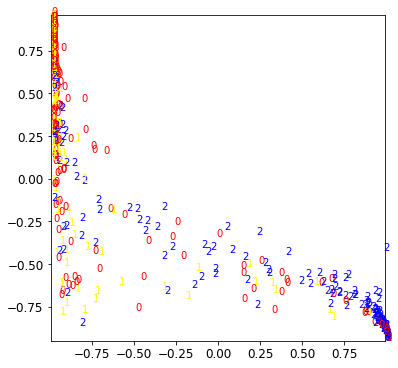

In [29]:
test_enc = encoder(XtestS)
print("Compressed output vector of encoder: {}".format(test_enc.shape))
plot_codings2d(test_enc.numpy(), Ttest)

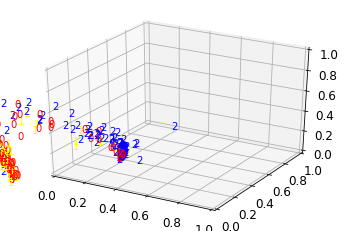

In [30]:
plot_codings3d(test_enc.numpy(), Ttest)

Take a second to observer the graphs. Do you notice any differences in the clustering of our labels?

# Classification

Now, let's build a classifier model that will replace the decoder model. Here we want to build a simple 2 layer model where our output now has the softmax activation function applied to it! See the below picture for the newly added classifier model. Notice that this new classifier model is very similar to the decoder, except the output is slightly different.
<img src="https://i.imgur.com/9u8nhln.png" width="400">

### TODO:

Use the above picture to build the classifier model. We'll combine encoder and classifier models into one to then make predictions!

1. Build the classifier model. Here, we need to build a `keras.Sequential` model with a ` keras.layers.Input` layer and 2 `keras.layers.Dense` layers. The input layer should have a **1-dimensional** shape equal to the output of the encoder, i.e. (3,). The first dense layer should have 6 hidden units with a tanh activation function. The second dense layer needs to match the number of classes in our data. Thus, the second dense layer needs to have 3 hidden units and a softmax activation function. Store the model into `classifier`.

In [41]:
# TODO (1)
classifier = keras.models.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(3, activation='tanh')
])

Here we combine the encoder and classifier to form our prediction model simply called `model`. Next, we compile our model. We use the sparse cross entropy loss, which does not require indicator variables,  and the NAdam optimizer. Lastly, we specify the accuracy metric should be tracked.

In [42]:
model = keras.models.Sequential([keras.layers.Input(shape=(D,)), encoder, classifier])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [43]:
history = model.fit(XtrainS, Ttrain, epochs=20, validation_data=[XtestS, Ttest])

Train on 3342 samples, validate on 835 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
3342/3342 [==============================] - 0s 118us/sample - loss: 3.3678 - acc: 0.2609 - val_loss: 2.5049 - val_acc: 0.2287
Epoch 2/20
3342/3342 [==============================] - 0s 45us/sample - loss: 2.0232 - acc: 0.2627 - val_loss: 2.1779 - val_acc: 0.2467
Epoch 3/20
3342/3342 [==============================] - 0s 42us/sample - loss: 1.7599 - acc: 0.2681 - val_loss: 1.8461 - val_acc: 0.2587
Epoch 4/20
3342/3342 [==============================] - 0s 43us/sample - loss: 1.5885 - acc: 0.3244 - val_loss: 1.7831 - val_acc: 0.3497
Epoch 5/20
3342/3342 [==============================] - 0s 40us/sample - loss: 1.5440 - acc: 0.3654 - val_loss: 1.6342 - val_acc: 0.3341
Epoch 6/20
3342/3342 [==============================] - 0s 37us/sample - loss: 1.4179 - acc: 0.3429 - val_loss: 1.5045 - val_acc: 0.3126
Epoch 7/20
3342/3342 [==============

In [44]:
def plot_result(Y, T, title=None):
    """
        Plots predicted and true labels.
        
        Args:
            Y (numpy.ndarray): Predicted labels
            
            T (numpy.ndarray): True labels
            
            title (str): Title for the plot
    """
    if len(T.shape) > 1:
        T = T.squeeze()
    # plot in sorted order
    sorted_i = np.argsort(T)

    plt.figure(figsize=[5,5])
    plt.plot(Y[sorted_i], 'b.', label="prediction")
    plt.plot(T[sorted_i], 'r-', label="target")
    plt.legend()
    plt.ylabel("Rings")
    plt.xlabel("Samples")
    plt.ylim([-1,4])
    plt.title(title)
    
    # accuracy
    print("Acc: {} %".format(100 * np.sum(Y==T)/T.shape[0]))

### TODO: 

1. Compute the probabilities for our `XtestS` data by using the `.predict()` method on our `model`. Store the output into `Ytest_probs`.
2. Compute the predictions by taking the `np.argmax()` of our probability array `Ytest_probs`. Store the output into `Ytest`.
    1. Note: Be sure to take the argmax over the correct axis, i.e. the row axis. 
3. Plot the results using the `plot_results()` function

Acc: 58.08383233532934 %


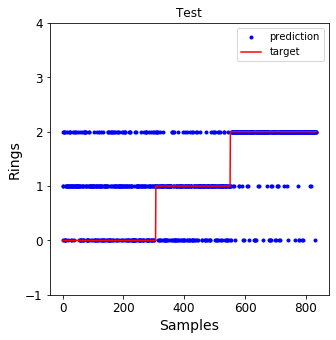

In [35]:
#TODO (1)
Ytest_probs =
# TODO (2)
Ytest = 
# TODO (3)


What do you think about the results?

### BONUS TODO (1):

You may want to try different structure and different parameters to improve the results above. 
Try different number of hidden units in the bottleneck layer. Do you see any difference in the level of accuracy?

**Note, do not try to plot the results using the `plot_codings3d()` and `plot_codings2d()` functions if you change the number of hidden units for the bottleneck! These plots will no work if you do!**